In [2]:
!pip install transformers
!pip install sentence_transformers
!pip install torchtext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 1.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torchtext
import torchtext.vocab as vocab
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sentence_transformers import SentenceTransformer, util
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

In [4]:
#seed random number generator
torch.manual_seed(0)

In [5]:
device = torch.device("cuda")

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Prepare the dataset
# Read the CSV file
data = pd.read_csv('/content/drive/MyDrive/cdata/stealing_data.csv')

# Splitting data into features and labels
X = data['tweet'].values

# Splitting the dataset into training and validation sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Creating DataFrame for training and validation sets
train_data = pd.DataFrame({'tweet': X_train})
test_data = pd.DataFrame({'tweet': X_test})

In [8]:
train_data

,tweet
0,RT @FunSizedYogi: @TheBlackVoice well how else...
1,Funny thing is....it's not just the people doi...
2,"RT @winkSOSA: ""@AintShitSweet__: ""@Rakwon_OGOD..."
3,@Jbrendaro30 @ZGabrail @ramsin1995 @GabeEli8 @...
4,S/o that real bitch
...,...
19821,The last at-bat at Yankee Stadium. Thanks for ...
19822,@_bradleey LMFAOOOO yooo I lost my elevator pa...
19823,"#porn,#android,#iphone,#ipad,#sex,#xxx, | #Ana..."
19824,RT @JennyJohnsonHi5: Just when I thought Justi...


In [9]:
test_data

,tweet
0,934 8616\ni got a missed call from yo bitch
1,RT @KINGTUNCHI_: Fucking with a bad bitch you ...
2,RT @eanahS__: @1inkkofrosess lol my credit ain...
3,RT @Maxin_Betha Wipe the cum out of them faggo...
4,Niggas cheat on they bitch and don't expect no...
...,...
4952,@GrizzboAdams @wyattnuckels haha ight nig calm...
4953,When you see kids being bad &amp; their parent...
4954,This bitch done blew my high
4955,Fat Trel that niggah &#128076;


In [10]:
# Target Model

# # Load tokenizer and model
# tokenizer = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
# model = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
# # This one said non-hate to a lot of hate speech as far as I have tried.

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english")
target_model = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/dehatebert-mono-english").to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

In [11]:
# For validation w.r.t. the target model (but does it technically increases the number of queries?)
def get_label(input_text):
    inputs = tokenizer(input_text, return_tensors="pt").to(device)

    # Query the target model
    with torch.no_grad():
        target_outputs = target_model(**inputs)

    target_labels = target_outputs.logits.softmax(dim=1).tolist()[0]
    return target_labels

test_data['label'] = test_data['tweet'].apply(get_label) # ~ 2/3 mins
test_data

,tweet,label
0,934 8616\ni got a missed call from yo bitch,"[0.554031491279602, 0.44596850872039795]"
1,RT @KINGTUNCHI_: Fucking with a bad bitch you ...,"[0.37748023867607117, 0.6225197315216064]"
2,RT @eanahS__: @1inkkofrosess lol my credit ain...,"[0.9582732319831848, 0.04172679781913757]"
3,RT @Maxin_Betha Wipe the cum out of them faggo...,"[0.09527343511581421, 0.904726505279541]"
4,Niggas cheat on they bitch and don't expect no...,"[0.11824338138103485, 0.881756603717804]"
...,...,...
4952,@GrizzboAdams @wyattnuckels haha ight nig calm...,"[0.09661740064620972, 0.9033826589584351]"
4953,When you see kids being bad &amp; their parent...,"[0.35169053077697754, 0.6483094096183777]"
4954,This bitch done blew my high,"[0.21178995072841644, 0.7882100939750671]"
4955,Fat Trel that niggah &#128076;,"[0.08707568049430847, 0.9129243493080139]"


In [13]:
# Pre-trained embeddings
# Load pre-trained GloVe embeddings
embed_dim = 100
import numpy as np

def load_glove_as_index_and_matrix(file):
    print("Loading GloVe model as index and matrix")
    with open(file, 'r', encoding='utf-8') as f:
        words = []
        embeddings = []
        for line in tqdm(f):
            split_line = line.split()
            word = split_line[0]
            embedding = np.array([float(val) for val in split_line[1:]], dtype=np.float32)
            words.append(word)
            embeddings.append(embedding)
        word_to_idx = {word: idx for idx, word in enumerate(words)}
        embedding_matrix = np.array(embeddings)
    print(f"Loaded {len(word_to_idx)} words.")
    return word_to_idx, embedding_matrix

# Load embeddings and convert to a PyTorch tensor
glove_path = '/content/drive/MyDrive/cdata/glove.6B.100d.txt'
glove_vocab, glove_embeddings = load_glove_as_index_and_matrix(glove_path)
pretrained_embeddings = torch.tensor(glove_embeddings).to(device)

Loading GloVe model as index and matrix


400000it [00:19, 20449.95it/s]


Loaded 400000 words.


In [14]:
# Clone Model class
class HateSpeechGRU(nn.Module):
    def __init__(self, pretrained_embeddings, hidden_size, output_dim, dropout):
        super(HateSpeechGRU, self).__init__()

        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.gru = nn.GRU(embed_dim, hidden_size, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_dim)  # * 2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)  # text: [batch size, sent len]
        output, hidden = self.gru(embedded)  # output: [batch size, sent len, hidden_size * num_directions]
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)  # concatenate the final forward and backward hidden states
        hidden = self.dropout(hidden)
        output = self.fc(hidden)  # output: [batch size, output dim]
        return output

In [16]:
# Clone Model
# Define hyperparameters
hidden_size = 128  # Size of hidden states in the GRU
output_dim = 2  # Number of output classes (binary classification)
dropout = 0.5  # Dropout probability

clone_model = HateSpeechGRU(pretrained_embeddings, hidden_size, output_dim, dropout).to(device)

In [17]:
# Load pre-trained Sentence Transformer model
sent_transformer = SentenceTransformer("all-MiniLM-L6-v2").to(device)

# Create the embeddings for the training data
# ~ 30 secs
train_embeddings = sent_transformer.encode(train_data['tweet'].tolist(), convert_to_tensor=True).tolist()

#normalize the embeddings
train_embeddings = torch.tensor(train_embeddings).to(device)
print(train_embeddings.shape)
train_embeddings = nn.functional.normalize(train_embeddings, p=2, dim=1)
print(train_embeddings.shape)

train_data['embedding'] = train_embeddings.cpu().tolist()
train_data

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

torch.Size([19826, 384])
torch.Size([19826, 384])


,tweet,embedding
0,RT @FunSizedYogi: @TheBlackVoice well how else...,"[-0.04517168551683426, 0.13797102868556976, 0...."
1,Funny thing is....it's not just the people doi...,"[0.0502471961081028, 0.0015787219163030386, 0...."
2,"RT @winkSOSA: ""@AintShitSweet__: ""@Rakwon_OGOD...","[-0.11634157598018646, 0.04812651500105858, 0...."
3,@Jbrendaro30 @ZGabrail @ramsin1995 @GabeEli8 @...,"[-0.15736792981624603, -0.020282872021198273, ..."
4,S/o that real bitch,"[-0.11650451272726059, -0.026171324774622917, ..."
...,...,...
19821,The last at-bat at Yankee Stadium. Thanks for ...,"[-0.02716938965022564, 0.1143580824136734, 0.0..."
19822,@_bradleey LMFAOOOO yooo I lost my elevator pa...,"[-0.028217779472470284, -0.05430901423096657, ..."
19823,"#porn,#android,#iphone,#ipad,#sex,#xxx, | #Ana...","[0.02086050435900688, -0.0533132441341877, 0.0..."
19824,RT @JennyJohnsonHi5: Just when I thought Justi...,"[0.009069069288671017, -0.011038331314921379, ..."


In [25]:
# Table to store the previous queries (for wise query selection later)
table = pd.DataFrame({
    'tweet': [],
    'embedding': [],
    't_out': [],
    'c_out': [],
    'count': []
})

alpha = 0.7
initial_alpha = alpha
final_alpha = 0.4
decay_rate = np.log(final_alpha / initial_alpha) / 100  # Calculate decay rate to reach final_alpha in 100 iterations

# Initial weight for the 'similarity with the previous queries that had high disagreement' term
beta = 1 - alpha#

# Train the clone model
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)
#optimizer = torch.optim.SGD(clone_model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(clone_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)  # Decay LR by 0.99 each epoch


batch_size = 128

# Define number of epochs
epoch = 0

loss_vals = []
best_loss = float('inf')

scaler = GradScaler()

repeated_counts = []

# Training loop

while True:
    clone_model.train()

    if table.shape[0] == 0: # Cold start for the first query (can be random)
        idxs = torch.randperm(len(train_data))[:batch_size].tolist()
    else:
        # Wise query selection
        # Calculate the cosine similarity between the embeddings of the training data and the table
        similarities = util.cos_sim(torch.tensor(train_data['embedding'].tolist()), torch.tensor(table['embedding'].tolist()))

        # Calculate the average cosine similarity for each training data
        # 'dissimilariy with the previous queries'
        avg_similarities = similarities.max(dim=1).values

        # 'similarity with the previous queries that had hish disagreement'
        disagreement = torch.tensor((abs(table['c_out'] - table['t_out'])).tolist())

        similarities = similarities * disagreement
        avg_wrt_disagreement = similarities.mean(dim=1)

        # Calculating Z-scores for avg_similarities and avg_wrt_disagreement
        avg_similarities_z = (avg_similarities - avg_similarities.mean()) / avg_similarities.std()
        avg_wrt_disagreement_z = (avg_wrt_disagreement - avg_wrt_disagreement.mean()) / avg_wrt_disagreement.std()

        # Calculate the normalized formula for each training data
        formula = alpha * (-avg_similarities_z) + beta * avg_wrt_disagreement_z

        # Get the index of the training data with the lowest average cosine similarity
        idxs = formula.argsort(descending=True)[:batch_size].tolist()

        #print('argsorted formula', formula.sort(descending=True)[:batch_size])

    input_texts = train_data.iloc[idxs]['tweet']

    # Check if the input_texts are already queried
    will_added = [True] * len(input_texts)

    count = 0
    for t in range(len(input_texts)):
        if input_texts.iloc[t] in table['tweet'].tolist():
            will_added[t] = False
            count += 1
            table.loc[table['tweet'] == input_texts.iloc[t], 'count'] += 1
    print('girdigi sayi', count)
    repeated_counts.append(count)


    input_embeds = train_data.iloc[idxs]['embedding']

    # inputs = tokenizer(input_text, return_tensors="pt")
    input_tokens = tokenizer(input_texts.tolist(), return_tensors="pt", padding=True, truncation=False).to(device)

    # Query the target model
    with torch.no_grad():
        target_outputs = target_model(**input_tokens)

    target_labels = target_outputs.logits.softmax(dim=1).tolist()

    # Conver input_text to tensor using glove_vocab
    input_glove = [[glove_vocab[word] if word in glove_vocab else glove_vocab['unk'] for word in input_text.split()] for input_text in input_texts]
    max_len = max([len(input_text) for input_text in input_glove])
    input_glove = [input_text + [glove_vocab['unk']] * (max_len - len(input_text)) for input_text in input_glove]
    input_glove = torch.tensor(input_glove, dtype=torch.long).to(device)

    target_outputs = torch.tensor(target_labels).to(device)

    # Forward pass through the clone model
    with autocast():
        clone_logits = clone_model(input_glove)
        clone_outputs = torch.softmax(clone_logits, dim=-1)
        loss = criterion(clone_outputs, target_outputs)

    optimizer.zero_grad()

    scaler.scale(loss).backward()

    # Update model weights considering the scaled gradients
    scaler.step(optimizer)

    # Updates the scale for next iteration
    scaler.update()
    scheduler.step()  # Update learning rate decay

    #update alpha and beta values
    alpha = initial_alpha * np.exp(decay_rate * epoch)
    beta = 1 - alpha

    input_texts = input_texts[will_added]
    input_embeds = input_embeds[will_added]
    target_outputs = target_outputs[will_added]
    clone_outputs = clone_outputs[will_added]

    # Add row to table
    row = pd.DataFrame({'tweet': input_texts, 'embedding': input_embeds, 't_out': target_outputs[:,0].tolist(), 'c_out': clone_outputs[:,0].tolist(), 'count': [1] * sum(will_added)})
    table = pd.concat([table, row], ignore_index=True)

    # Evaluation
    clone_model.eval()

    with torch.inference_mode():

        # Updating the table
        input_glove_2 = [[glove_vocab[word] if word in glove_vocab else glove_vocab['unk'] for word in input_text.split()] for input_text in table['tweet'].tolist()]
        max_len = max([len(input_text) for input_text in input_glove_2])
        input_glove_2 = [input_text + [glove_vocab['unk']] * (max_len - len(input_text)) for input_text in input_glove_2]

        input_glove_2 = torch.tensor(input_glove_2, dtype=torch.long).to(device)

        with autocast():
            clone_logits_2 = clone_model(input_glove_2)
            clone_outputs_2 = torch.softmax(clone_logits_2, dim=-1)

        table['c_out'] = clone_outputs_2[:,0].tolist()

        # Validation set
        inputs = [[glove_vocab[word] if word in glove_vocab else glove_vocab['unk'] for word in txt.split()] for txt in test_data['tweet'].tolist()] # TODO: Do once, don't do it in every epoch
        max_len = max([len(txt) for txt in inputs])
        inputs = [txt + [glove_vocab['unk']] * (max_len - len(txt)) for txt in inputs]


        test_pred = clone_model(torch.tensor(inputs, device=device))
        test_loss = criterion(test_pred, torch.tensor(test_data['label'].tolist(), device=device))

    loss_val = test_loss.item()
    loss_vals.append(loss_val)
    print(f'Epoch [{epoch + 1}], Loss: {loss_val}')
    loss_vals.append(loss_val)

    # Check if this is the best loss we've seen
    if loss_val < best_loss:
        best_loss = loss_val
        best_model_weights = clone_model.state_dict()
        best_table = table.copy()

    epoch += 1

    print('table size ' ,table.shape)

girdigi sayi 0
Epoch [1], Loss: 0.7084465622901917
table size  (128, 5)
girdigi sayi 0
Epoch [2], Loss: 0.6854012608528137
table size  (256, 5)
girdigi sayi 0
Epoch [3], Loss: 0.6841815114021301
table size  (384, 5)
girdigi sayi 0
Epoch [4], Loss: 0.6990377306938171
table size  (512, 5)
girdigi sayi 0
Epoch [5], Loss: 0.7151316404342651
table size  (640, 5)
girdigi sayi 0
Epoch [6], Loss: 0.7204546928405762
table size  (768, 5)
girdigi sayi 0
Epoch [7], Loss: 0.714789092540741
table size  (896, 5)
girdigi sayi 0
Epoch [8], Loss: 0.7033807635307312
table size  (1024, 5)
girdigi sayi 0
Epoch [9], Loss: 0.6923044919967651
table size  (1152, 5)
girdigi sayi 0
Epoch [10], Loss: 0.6834856271743774
table size  (1280, 5)
girdigi sayi 0
Epoch [11], Loss: 0.6788420081138611
table size  (1408, 5)
girdigi sayi 0
Epoch [12], Loss: 0.6784711480140686
table size  (1536, 5)
girdigi sayi 0
Epoch [13], Loss: 0.6829887628555298
table size  (1664, 5)
girdigi sayi 0
Epoch [14], Loss: 0.6905020475387573
tab

KeyboardInterrupt: 

Best Loss: 0.6845911741256714  at iteration:  66


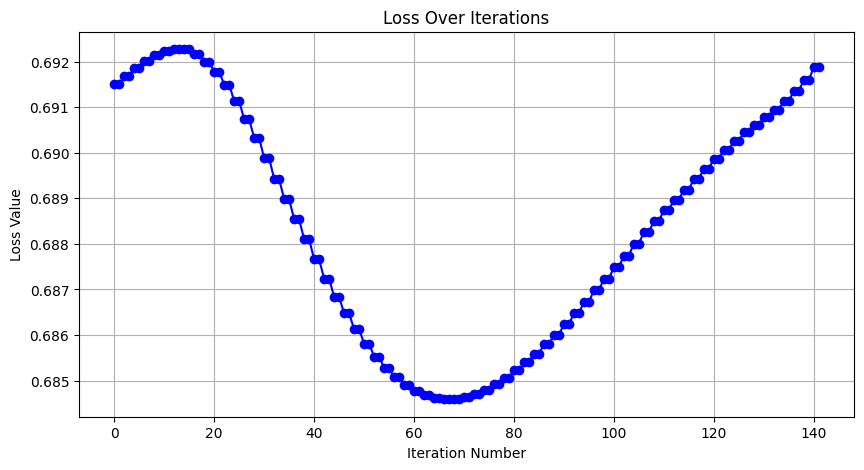

In [23]:
#SGD
print('Best Loss:',best_loss,' at iteration: ', loss_vals.index(best_loss))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_vals, marker='o', linestyle='-', color='b')
plt.title('Loss Over Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()

Best Loss: 0.6784711480140686  at iteration:  22


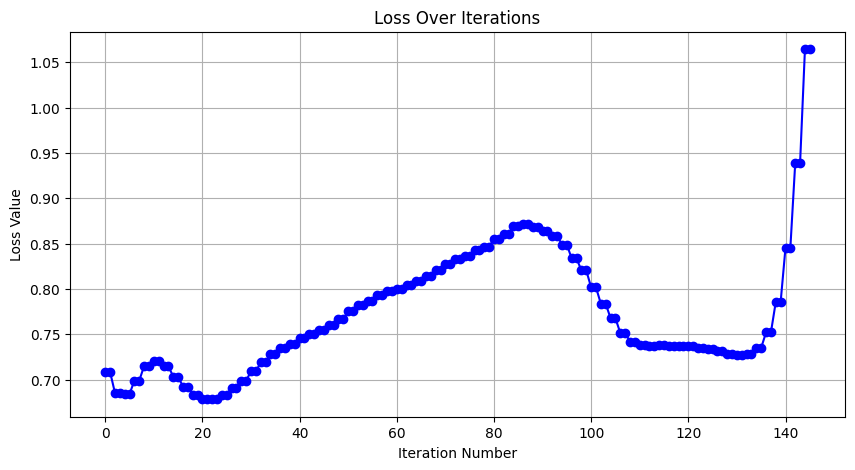

In [26]:
#ADAM
print('Best Loss:',best_loss,' at iteration: ', loss_vals.index(best_loss))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_vals, marker='o', linestyle='-', color='b')
plt.title('Loss Over Iterations')
plt.xlabel('Iteration Number')
plt.ylabel('Loss Value')
plt.grid(True)
plt.show()